In [530]:
%reset

In [531]:
import torch.utils.data as data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler
import torch
import abc
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from typing import List
import numpy as np
from sklearn.utils import class_weight

#### Set up criteria for classifying the data

In [532]:
CRITERIUM_MAX_AVERAGE = 350000
CRITERIUM_MAX_CHEAP = 100000

In [533]:
COLUMNS_TO_DUMMY = [
    "HeatingType",
    "AptManageType",
    "HallwayType",
    "TimeToBusStop",
    "TimeToSubway",
    "SubwayStation",
]
OUTPUT_COLUMN = "SalePrice"

# Create a dataset class for classification

In [615]:
class HouseDataset(data.Dataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.scaler = scaler
        self._prepare_data()
        self.headers = list(self.data.columns)
        self._to_tensor()
        self.size = self.data.shape[0]

    def __len__(self) -> int:
        return self.size

    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def _to_dummy_columns(self, columns: List[str]) -> pd.DataFrame:
        dummy_columns = pd.get_dummies(self.data, columns=columns).astype(float)
        return dummy_columns

    def prepare_for_training(self) -> None:
        self.data = self.get_data_as_pandas()
        self._multiply_data()
        self.shuffle()
        self._to_tensor()

    def _scale_data(self) -> None:
        for column in self.data:
            if column not in COLUMNS_TO_DUMMY and column != OUTPUT_COLUMN:
                self.data[column] = self.scaler.fit_transform(
                    self.data[column].values.reshape(-1, 1)
                )

    def _prepare_data(self) -> None:
        self.data = self._to_dummy_columns(columns=COLUMNS_TO_DUMMY)
        if self.scaler:
            self._scale_data()

    def _to_tensor(self) -> None:
        self.headers = list(self.data.columns)
        if OUTPUT_COLUMN in self.headers:
            self.label = torch.tensor(self.data.iloc[:,0].values, dtype=torch.float32)
            self.data = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)
        else:
            self.data = torch.tensor(self.data.values, dtype=torch.float32)
            self.label = None
        self.size = self.data.shape[0]

    def get_data_as_pandas(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        data = pd.DataFrame(self.data.numpy())
        labels = pd.DataFrame(self.label.numpy())
        df = pd.concat([labels, data], axis=1)
        df.columns = self.headers
        return df

    @abc.abstractmethod
    def _multiply_data(self) -> None:
        return


    def shuffle(self):
        self.data.sample(frac=1)

In [624]:
class HouseDatasetClassification(HouseDataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__(path_to_csv, scaler)
        print(self.label)
        if self.label is not None:
            self._classify_data()

    def _classify_data(self) -> None:
        self.label = torch.where(
            self.label > CRITERIUM_MAX_AVERAGE,
            torch.tensor(2),
            torch.where(
                (self.label > CRITERIUM_MAX_CHEAP)
                & (self.label <= CRITERIUM_MAX_AVERAGE),
                torch.tensor(1),
                torch.tensor(0),
            ),
        )

    def _multiply_data(self) -> None:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(self.data.iloc[:,1:], self.data[OUTPUT_COLUMN])
        self.data = pd.concat([y, x], axis=1)

In [536]:
train_path = "../data/split_train_data/train_data.csv"
val_path = "../data/split_train_data/val_data.csv"
scaler = StandardScaler()

In [537]:
train_dataset_classify = HouseDatasetClassification(train_path, scaler)
train_dataset_classify.prepare_for_training()
train_dataset_classify_df = train_dataset_classify.get_data_as_pandas()

val_dataset_classify = HouseDatasetClassification(val_path, scaler)
# train_dataset_classify_df = train_dataset_classify.get_data_as_pandas()

In [538]:
# Display the data

In [539]:
train_dataset_classify_df

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0.0,0.202324,-1.019485,0.641248,-0.571717,0.535631,-0.096317,-1.424494,0.480494,0.928305,...,2.021979,-0.199736,2.634323,-0.378980,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,-0.275562
1,1.0,0.432564,-0.245248,-0.400815,-0.886559,1.687585,2.379252,0.650023,1.751334,-0.232155,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,1.620489,-0.580833,-0.351607,-0.275562
2,2.0,1.353523,-0.124927,-0.661331,-0.064211,1.812055,0.522575,1.687281,1.751334,-1.102500,...,2.021979,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,3.628943
3,0.0,-1.294234,-1.009022,0.120216,0.053267,-1.411954,-0.405763,-0.127921,-1.213960,1.798650,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,1.721666,-0.351607,-0.275562
4,1.0,-1.179114,1.279685,1.683310,1.571086,-0.103802,0.522575,1.168652,-0.790347,1.218420,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,1.721666,-0.351607,-0.275562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6010,2.0,1.238403,0.340661,-0.400815,-0.463637,1.453289,0.213129,1.168652,1.327721,1.218420,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,1.721666,-0.351607,-0.275562
6011,2.0,0.432564,1.781893,0.641248,-0.886559,1.687585,2.379252,0.650023,1.751334,-0.232155,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,1.620489,-0.580833,-0.351607,-0.275562
6012,2.0,1.238403,0.759168,0.250474,1.307935,-0.916516,-0.405763,0.131394,1.751334,-2.843189,...,-0.494565,-0.199736,-0.379604,2.638662,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,-0.275562
6013,2.0,0.432564,1.781893,-1.312620,-0.886559,1.687585,2.379252,0.650023,1.751334,-0.232155,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,1.620489,-0.580833,-0.351607,-0.275562


In [540]:
train_dataset_classify_df.iloc[:, 0].value_counts()

SalePrice
0.0    2005
1.0    2005
2.0    2005
Name: count, dtype: int64

# Classification model

In [541]:
class HousingClassificationModel(nn.Module):
    def __init__(self, input_size: int, class_num: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 36)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(36, 24)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(24,  class_num)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        # x = self.bn2(x)
        x = self.fc3(x)
        return x

####  Prepare loaders and set batch size

In [542]:
batch_size = 32
train_loader_classify = data.DataLoader(train_dataset_classify, batch_size=batch_size, shuffle=True)
validation_loader_classify = data.DataLoader(val_dataset_classify, batch_size=batch_size, shuffle=True)

In [543]:
train_dataset_classify.label

tensor([0., 1., 2.,  ..., 2., 2., 2.])

#### Set up the model, optimizer and loss function

In [544]:
model_classify = HousingClassificationModel(input_size=train_dataset_classify.data.shape[1], class_num=3)
optimizer = torch.optim.Adam(model_classify.parameters(), lr=0.0001)
loss_fn_classify = nn.CrossEntropyLoss(torch.tensor([0.7,2.4, 1.12]))
mca = MulticlassAccuracy(num_classes=3, average=None)

# Train the model

In [545]:
EPOCHS_NUMBER = 420
train_losses, train_accuracies, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num, v_batch_num = len(train_loader_classify), len(validation_loader_classify)

for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0

    model_classify.train()
    for data_patch, label in train_loader_classify:
        model_output = model_classify(data_patch).squeeze()
        loss = loss_fn_classify(model_output, label.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        optimizer.zero_grad()
        train_batch_accuracy_sum += mca(torch.argmax(model_output, dim=1), label)
        train_batch_f1_score_sum += f1_score(torch.argmax(model_output, dim=1), label, average="micro")

    train_batch_loss_avg = train_batch_loss_sum / t_batch_num
    train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num
    train_batch_f1_score_avg = train_batch_f1_score_sum / t_batch_num

    train_losses.append(train_batch_loss_avg)
    train_accuracies.append(train_batch_accuracy_avg)
    train_f1_scores.append(train_batch_f1_score_avg)
    
    model_classify.eval()
    for val_inputs, val_labels in validation_loader_classify:
        val_predicts = model_classify(val_inputs).squeeze(dim=1)
        val_loss = loss_fn_classify(val_predicts, val_labels.type(torch.LongTensor))
        val_batch_loss_sum += val_loss.item()
        val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)
        val_batch_f1_score_sum += f1_score(
            torch.argmax(val_predicts, dim=1), val_labels, average="micro"
        )
    val_batch_loss_avg = val_batch_loss_sum / v_batch_num
    val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num
    val_batch_f1_score_avg = val_batch_f1_score_sum / v_batch_num
    
    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(val_batch_loss_avg)
    val_f1_scores.append(val_batch_f1_score_avg)
    
    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_batch_loss_avg},
            "Loss in eval": {val_batch_loss_avg},
            "f1 in train": {train_batch_f1_score_avg},
            "f1 in eval": {val_batch_f1_score_avg},
        }
    )

  0%|          | 1/420 [00:01<07:04,  1.01s/it, Epoch=1, Los in train={1.0588156238515327}, Loss in eval={1.020615551360818}, f1 in train={0.5430089653397392}, f1 in eval={0.5681002051983585}]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    predicts_train = model_classify(train_dataset_classify.data.clone().detach())
    predicts_val = model_classify(val_dataset_classify.data.clone().detach())
    predicted_argmax_train = torch.argmax(predicts_train, dim=1)
    predicted_argmax_val = torch.argmax(predicts_val, dim=1)

In [ ]:
val_accuracies

In [ ]:
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
plt.plot(train_f1_scores, label="Train")
plt.plot(val_f1_scores, label="Validation")
plt.legend()
plt.title("F1 score")
plt.xlabel("Epochs")
plt.ylabel("F1 score")

In [ ]:
val_accuracies

In [ ]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]
val_accuracies_mean = [tensor.mean().item() for tensor in val_accuracies]

In [ ]:
plt.plot(train_accuracies_mean, label="Train")
plt.plot(val_accuracies_mean, label="Validation")
plt.legend()
plt.title("Accuracy mean for all classes")
plt.xlabel("Epochs")
plt.ylabel("Accuracy mean")

In [ ]:
conf_matrix_val = confusion_matrix(val_dataset_classify.label, predicted_argmax_val)
ConfusionMatrixDisplay(conf_matrix_val).plot()
plt.show()

In [ ]:
f1_score(val_dataset_classify.label, predicted_argmax_val, average="micro")

In [ ]:
mca(predicted_argmax_val, val_dataset_classify.label)

In [ ]:
torch.save(model_classify.state_dict(), "../final_models/classification_model_without_cv.pth")

In [ ]:
mca(predicted_argmax_train, train_dataset_classify.label)

# Train on whole dataset

In [589]:
whole_dataset_classify = HouseDatasetClassification("../data/train_data.csv", scaler)
whole_dataset_classify.prepare_for_training()
whole_loader_classify = data.DataLoader(whole_dataset_classify, batch_size=batch_size, shuffle=True)

In [590]:
model = HousingClassificationModel(input_size=whole_dataset_classify.data.shape[1], class_num=3)

In [603]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn_classify = nn.CrossEntropyLoss(torch.tensor([0.7,2.4, 1.12]))
mca = MulticlassAccuracy(num_classes=3, average=None)

In [604]:
EPOCHS_NUMBER = 420
train_losses, train_accuracies, train_f1_scores =  [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num= len(whole_loader_classify)

for epoch in tqdm_progress:
    train_batch_loss_sum = 0
    train_batch_accuracy_sum = 0
    train_batch_f1_score_sum= 0

    model.train()
    for data_patch, label in whole_loader_classify:
        model_output = model(data_patch).squeeze()
        loss = loss_fn_classify(model_output, label.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        optimizer.zero_grad()
        train_batch_accuracy_sum += mca(torch.argmax(model_output, dim=1), label)
        train_batch_f1_score_sum += f1_score(torch.argmax(model_output, dim=1), label, average="micro")

    train_batch_loss_avg = train_batch_loss_sum / t_batch_num
    train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num
    train_batch_f1_score_avg = train_batch_f1_score_sum / t_batch_num

    train_losses.append(train_batch_loss_avg)
    train_accuracies.append(train_batch_accuracy_avg)
    train_f1_scores.append(train_batch_f1_score_avg)
    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_batch_loss_avg},
            "f1 in train": {train_batch_f1_score_avg},
        }
    )

 14%|█▎        | 57/420 [00:19<02:06,  2.87it/s, Epoch=57, Los in train={0.28480964647175155}, f1 in train={0.8724421708185054}]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    predicts_whole = model_classify(whole_dataset_classify.data.clone().detach())
    predicted_argmax_whole = torch.argmax(predicts_whole, dim=1)

In [ ]:
conf_matrix_whole= confusion_matrix(whole_dataset_classify.label, predicted_argmax_whole)
ConfusionMatrixDisplay(conf_matrix_whole).plot()
plt.show()

In [595]:
f1_score(whole_dataset_classify.label, predicted_argmax_whole, average="micro")

0.6026069518716578

In [596]:
mca(predicted_argmax_whole, whole_dataset_classify.label)

tensor([0.2276, 0.7781, 0.8021])

 # Load the model

In [598]:
model_classify = HousingClassificationModel(input_size=whole_dataset_classify.data.shape[1], class_num=3)
model_classify.load_state_dict(torch.load("../final_models/classification_model_without_cv.pth"))

<All keys matched successfully>

In [599]:
with torch.no_grad():
    predicts_whole = model_classify(whole_dataset_classify.data.clone().detach())
    predicted_argmax_whole = torch.argmax(predicts_whole, dim=1)

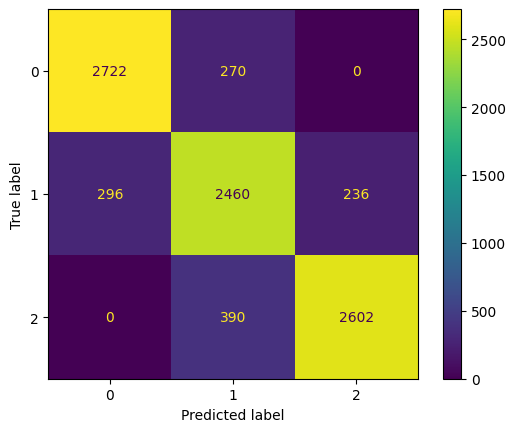

In [600]:
conf_matrix_whole= confusion_matrix(whole_dataset_classify.label, predicted_argmax_whole)
ConfusionMatrixDisplay(conf_matrix_whole).plot()
plt.show()

In [601]:
f1_score(whole_dataset_classify.label, predicted_argmax_whole, average="micro")

0.8672014260249554

In [602]:
mca(predicted_argmax_whole, whole_dataset_classify.label)

tensor([0.9098, 0.8222, 0.8697])

# Whole dataset predictions - save to csv

In [625]:
test_dataset = HouseDatasetClassification("../data/test_data.csv", scaler)

None


In [626]:
model_classify_whole = HousingClassificationModel(input_size=whole_dataset_classify.data.shape[1], class_num=3)
model_classify_whole.load_state_dict(torch.load("../final_models/classification_model_without_cv.pth"))

<All keys matched successfully>

In [627]:
with torch.no_grad():
    predicts_test_whole = model_classify(test_dataset.data.clone().detach())
    predicted_argmax_test_whole = torch.argmax(predicts_test_whole, dim=1)

In [628]:
numpy_data_whole = predicted_argmax_test_whole.numpy()
np.savetxt("../final_predictions/classification_data_without_cv.csv", numpy_data_whole, delimiter=",")